# An Analysis of News Head Lines Part 3
# Topic Modeling
### Noah Minshew

"On my honor, as a student, I have neither given nor received unauthorized aid on this academic work."

---

# Import Packages

In [1]:
#news api
from newsapi import NewsApiClient

#CSV
import csv
from collections import Counter

#pandas
import pandas as pd

#Matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
% matplotlib inline

#numpy
import numpy

# nltk
import nltk
# stopwords, FreqDist, word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

#regular expression
import re

#seaborn
import seaborn as sns

#pip install scikit-plot 
import scikitplot as skplt

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

C:\Users\nminshew\Anaconda2\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#https://radimrehurek.com/gensim/tutorial.html
# this makes process visible

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Read the data collected in the first notebook

In [3]:
df = pd.read_csv("data/headlineSent.csv")
df.head(2)

,Unnamed: 0,title,bias,source,category_senti
0,0,Michael Moore Hammers Media for Obsessive Cove...,Conservative,breitbart-news,Negative
1,1,TIJUANA: 11 Killed in 24 Hours...,Conservative,breitbart-news,Negative


In [4]:
#remove the unnamed column, we do not need it. 
del df['Unnamed: 0']

#### We will preform topic modeling for:
* All heeadlines
* Then analyize:
 * Conservative Headlines
 * Liberal Headlines
 * Positive Headlines
 * Negative Headlines

First we need to create a dataframe for each of these categories

In [5]:
#all headlines = df
#Conservative Headlines
df_c = df[df.bias=="Conservative"].copy()
#Liberal Headlines
df_l = df[df.bias=="Liberal"].copy()
#Positive Headlines
df_p = df[df.category_senti=="Positive"].copy()
#Negative Headlines
df_n = df[df.category_senti=="Negative"].copy()

In [6]:
#Declare list of stopwords including the names of our news sources
extra_stopwords = ["fox", "fox news", "breitbart", "national review", "national", "review", "the american conservative", 
             "american conservative", "the washington times", "washington times", "cnn", 
             "the new york times", "new york times", "the washington post", "washington post", 
             "the huffington post", "huffington post", "msnbc", "news", "contributor", 
             "columnist", "post", "contributing", "daily", "january", "march", "april", "may",
             "june", "july", "august", "september", "october", "november", "december", 
             "op ed", "writer", "opinion", "huffpost", "op", "ed", "say", "time", "new", "day", 
             "get", "post", "washington", "make", "want", "york", "could", "news", 'will', 'people', 
             'need', 'think', 'well','going', 'can', 'know', 'lot', 'get','make','way', 'want',
             'like','say','got','said','just','something','tell','put','now','back','want','right','every','one',
             'use','come','never', 'many','along','things','day','also','first','guy','take', 'good', 'much',
             'let', 'would', 'thing', 'talk', 'talking', 'thank', 'does', 'give', 'look', 'tonight','today', 
             'see', 'news', 'fox', 'new', 'may', 'could', 'show', 'time', 'american', 'conservative',
             'huffington', 'times', 'post', 'washington', 'the', 'fast', 'facts', 'week', 'high', 'last', 'says', 'years', 'next']

# Topic Modeling for All Headlines

Reference: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/lda_training_tips.ipynb

---

## Preprocessing
* Split the documents into tokens.
* Lemmatize the tokens.
* Compute bigrams.
* Compute a bag-of-words representation of the data.

In [7]:
texts = df['title'].values.tolist()

In [8]:
docs = []
for i in texts:
    a = str(i)
    docs.append(a)

In [9]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
# Remove words that are less than 3 characters.
docs = [[token for token in doc if len(token) > 3] for doc in docs]

In [10]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer
# Lemmatize all words in documents.
#lemmatizer = WordNetLemmatizer()
#docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
#We can use porter as well 
#porter_stemmer = PorterStemmer()
#docs = [[porter_stemmer.stem(token) for token in doc] for doc in docs]

In [11]:
#remove common stopwords
stoplist = stopwords.words('english')
docs = [[token for token in doc if token not in stoplist] for doc in docs]
#remove custom stopwords
extra_stoplist = extra_stopwords
docs = [[token for token in doc if token not in extra_stoplist] for doc in docs]

In [ ]:
#Add bigrams and Trigrams
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear at least 20 times)
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
## Create a dictionary representation of the documents
dictionary = Dictionary(docs)
## Remove rare and common tokens.
dictionary.filter_extremes(no_below=20, no_above=0.5) 
#save as unique dictionary for each category
dictionary.save('data/dict_all.dict') 

In [ ]:
# convert words to vetors or integers
corpus = [dictionary.doc2bow(doc) for doc in docs]
corpora.MmCorpus.serialize('data/corpus_all.mm', corpus)
len(corpus)

In [15]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 3626
Number of documents: 57416


### Determine best model

In [ ]:
#best model for all
numpy.random.seed(1) 
k_range = range(5,15)
scores = []
for k in k_range:
    goodLdaModel = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, passes=50)
    goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    print (k, goodcm.get_coherence())
    scores.append(goodcm.get_coherence())
    
plt.figure()
plt.plot(k_range, scores)

### Model with 5 topics which had the highest semantic coherance

In [ ]:
#build model with 5 topics
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5, passes=200)

In [ ]:
model.save('data/lda_k5_all.model')
#model = models.LdaModel.load('data/lda_k5_all.model')

In [ ]:
model = models.LdaModel.load('data/lda_k5_all.model')

In [43]:
# Print topics without probability
for i in range(0,5):
    topics = model.show_topic(i, 10)
    print (i,', '.join([str(word[0]) for word in topics]))

0 school, shooting, florida, parkland, students, week, facebook, death, video, high
1 trump, democrats, bill, senate, pruitt, last, house, scott, republican, republicans
2 trump, white, house, mueller, russia, white_house, president, russian, says, state
3 black, women, team, dead, years, history, next, fight, family, woman
4 trump, north, korea, stormy, daniels, stormy_daniels, china, comey, north_korea, deal


#### Topic Descriptions from 5 topics model:
1. The parkland school shooting
2. Politics: more specifically news about bills Scott Pruitt (head of EPA) is passing
3. News about the Trump Russia investigation
4. This topic is not very coherent
5. Trump and North Korea, Trump and Stormy Daniels 

While these topics look good for the most part, I believe 5 is too few for our large data set. Lets create a model with 20 topics. 

In [ ]:
#build lda model with 20 topics
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, passes=500)

In [ ]:
model.save('data/lda_k20_all.model')
#model = models.LdaModel.load('data/lda_k20_all.model')

In [45]:
model = models.LdaModel.load('data/lda_k20_all.model')

2018-05-07 11:03:45,905 : INFO : loading LdaModel object from data/lda_k20_all.model
2018-05-07 11:03:45,906 : INFO : loading expElogbeta from data/lda_k20_all.model.expElogbeta.npy with mmap=None
2018-05-07 11:03:45,907 : INFO : setting ignored attribute state to None
2018-05-07 11:03:45,908 : INFO : setting ignored attribute id2word to None
2018-05-07 11:03:45,908 : INFO : setting ignored attribute dispatcher to None
2018-05-07 11:03:45,908 : INFO : loaded data/lda_k20_all.model
2018-05-07 11:03:45,909 : INFO : loading LdaState object from data/lda_k20_all.model.state
2018-05-07 11:03:45,911 : INFO : loaded data/lda_k20_all.model.state


In [47]:
# print words without probability
for i in range(0,20):
    topics = model.show_topic(i, 10)
    print (i,', '.join([str(word[0]) for word in topics]))

0 bill, john, former, senate, race, without, spending, attorney, bolton, wins
1 trump, state, comey, gets, obama, union, republican, james, makes, legal
2 trump, deal, students, control, fight, violence, military, star, iran, full
3 america, trump, still, book, immigration, story, power, free, speech, possible
4 case, amid, officials, abuse, second, goes, ever, problem, debate, past
5 media, team, dies, talks, stop, game, love, interview, teacher, sessions
6 trump, stormy, daniels, stormy_daniels, cohen, michael, lawyer, help, michael_cohen, democratic
7 trump, russian, teachers, official, attacks, night, word, rights, despite, strike
8 death, video, shows, another, anti, judge, policy, nationals, care, wednesday
9 women, china, world, latest, dead, olympic, found, accused, clinton, three
10 russia, trump, memo, republicans, nunes, real, super, attack, fire, made
11 trump, president, black, donald, donald_trump, trade, democrats, campaign, putin, plan
12 mueller, trump, life, morning, 

In [ ]:
#Visualize topics
import pyLDAvis.gensim

In [60]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
11     6.621680        1       1 -0.226415  0.034528
14     5.852385        1       2 -0.117877 -0.052839
17     5.650438        1       3  0.135202 -0.180466
1      5.254606        1       4 -0.147842  0.035384
10     5.236496        1       5 -0.147709 -0.071996
8      5.146439        1       6  0.137439  0.206066
6      5.140558        1       7 -0.156228  0.018654
15     5.105152        1       8  0.131300  0.117798
2      5.036028        1       9 -0.078550 -0.018463
9      4.974407        1      10  0.132912  0.123560
16     4.926695        1      11  0.022257  0.137646
12     4.912199        1      12 -0.155491  0.057095
7      4.911294        1      13 -0.150164 -0.020054
13     4.704972        1      14  0.129709  0.104330
18     4.592040        1      15  0.148681  0.054522
19     4.556790        1      16  0.118343 -0.257035
5      4.492668        1      17  0.136377 -0.065324
4      4.378020        1      18  0.103629 -0.112029
3      4.298843        1      19 -0.113985 -0.023068
0      4.208293        1      20  0.098411 -0.088311, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
63    Default  10502.000000        trump  10502.000000  30.0000  30.0000
74    Default   1654.000000        house   1654.000000  29.0000  29.0000
79    Default   1368.000000        white   1368.000000  28.0000  28.0000
4     Default   1168.000000       russia   1168.000000  27.0000  27.0000
812   Default   1132.000000      mueller   1132.000000  26.0000  26.0000
80    Default   1085.000000  white_house   1085.000000  25.0000  25.0000
77    Default   1032.000000    president   1032.000000  24.0000  24.0000
87    Default    971.000000        state    971.000000  23.0000  23.0000
373   Default    794.000000        north    794.000000  22.0000  22.0000
372   Default    780.000000        korea    780.000000  21.0000  21.0000
782   Default    767.000000     shooting    767.000000  20.0000  20.0000
49    Default    692.000000        women    692.000000  19.0000  19.0000
949   Default    677.000000         memo    677.000000  18.0000  18.0000
815   Default    636.000000      florida    636.000000  17.0000  17.0000
123   Default    610.000000         year    610.000000  16.0000  16.0000
374   Default    583.000000  north_korea    583.000000  15.0000  15.0000
221   Default    585.000000        china    585.000000  14.0000  14.0000
261   Default    549.000000      america    549.000000  13.0000  13.0000
114   Default    907.000000       school    907.000000  12.0000  12.0000
252   Default    560.000000      russian    560.000000  11.0000  11.0000
42    Default    556.000000        world    556.000000  10.0000  10.0000
5     Default    559.000000       stormy    559.000000   9.0000   9.0000
15    Default    547.000000   california    547.000000   8.0000   8.0000
1826  Default    531.000000      daniels    531.000000   7.0000   7.0000
154   Default    728.000000        syria    728.000000   6.0000   6.0000
798   Default    578.000000         bill    578.000000   5.0000   5.0000
543   Default    489.000000        still    489.000000   4.0000   4.0000
127   Default    640.000000     facebook    640.000000   3.0000   3.0000
336   Default    493.000000         deal    493.000000   2.0000   2.0000
892   Default    511.000000     parkland    511.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
2759  Topic20    194.688583       bolton    195.638428   3.1632  -4.1077
1413  Topic20    186.361328         wins    187.311172   3.1630  -4.1514
34    Topic20    181.291718       europe    182.241562   3.1629  -4.1790
153   Topic20    180.917542        plans    181.867386   3.1629  -4.1811
305   Topic20    178.691925         find    179.641769   3.1628  -4.1935
758   Topic20    

In [181]:
#append results to data
lda_corpus = model[corpus]

results = []

for i in lda_corpus:
    results.append(i)
print 

<function print>

In [182]:
# finding highest value from each row
toptopic = [max(collection, key=lambda x: x[1])[0] for collection in results]

In [208]:
#creat list of more descriptive labels
label_list = []
for i in range(0,20):
    topics = model.show_topic(i, 3)
    a = (', '.join([str(word[0]) for word in topics]))
    labels.append(['Topic:' + str(i) + ' ' + str(a)])

In [183]:
#creat list of more descriptive labels for dataframe
labels = []
for i in toptopic:
    topics = model.show_topic(i, 3)
    a = (', '.join([str(word[0]) for word in topics]))
    labels.append(['Topic:' + str(i) + ' ' + str(a)])

In [184]:
#create df with topic 
toptopic = pd.DataFrame(toptopic)
documents = pd.DataFrame(df)
summary = documents.join(toptopic)
summary = summary.rename(columns = {0: 'topic'})

In [185]:
#create df with both topic and descriptive label
label = pd.DataFrame(labels)
summary = summary.join(label)
summary = summary.rename(columns = {0: 'label'})
summary.head()

,title,bias,source,category_senti,topic,label
0,Michael Moore Hammers Media for Obsessive Cove...,Conservative,breitbart-news,Negative,6,"Topic:6 trump, stormy, daniels"
1,TIJUANA: 11 Killed in 24 Hours...,Conservative,breitbart-news,Negative,0,"Topic:0 bill, john, former"
2,Actor attacks in obscenity-filled rant...,Conservative,breitbart-news,Negative,17,"Topic:17 shooting, florida, school"
3,Baseball Viewership Lowest in Decade...,Conservative,breitbart-news,Negative,5,"Topic:5 media, team, dies"
4,California Trains Running Even Slower Due to H...,Conservative,breitbart-news,Negative,2,"Topic:2 trump, deal, students"


### Visualize Topic by political bias

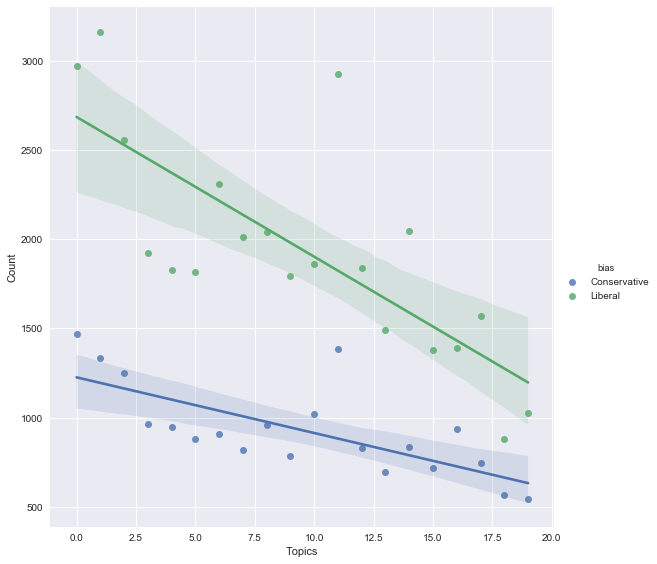

In [186]:
df1 = summary.groupby(['bias', 'topic']).count()
df1 = df1.reset_index()
import seaborn as sns
sns.set()

# Plot tip as a function of toal bill across days
g = sns.lmplot(x="topic", y="title", hue="bias",
               truncate=True, size=8, data=df1)

# Use more informative axis labels than are provided by default
g= (g.set_axis_labels("Topics", "Count"))

#### Findings: 
* Conservatives reported heavily on these topics:
 * Topic 0: John Bolton the new secretary of defense. 
 * Topic 11: Trump and Putin connections
 * Topic 16 North Korea
* Liberals reported Heavily on topics: 
 * Topic 1: Trump and James Comey (the former FBI director Trump fired)
 * Topic 14: Rob Porter a Trump advisor who was accused of domestic abuse

### Visualize Topic by Sentiment

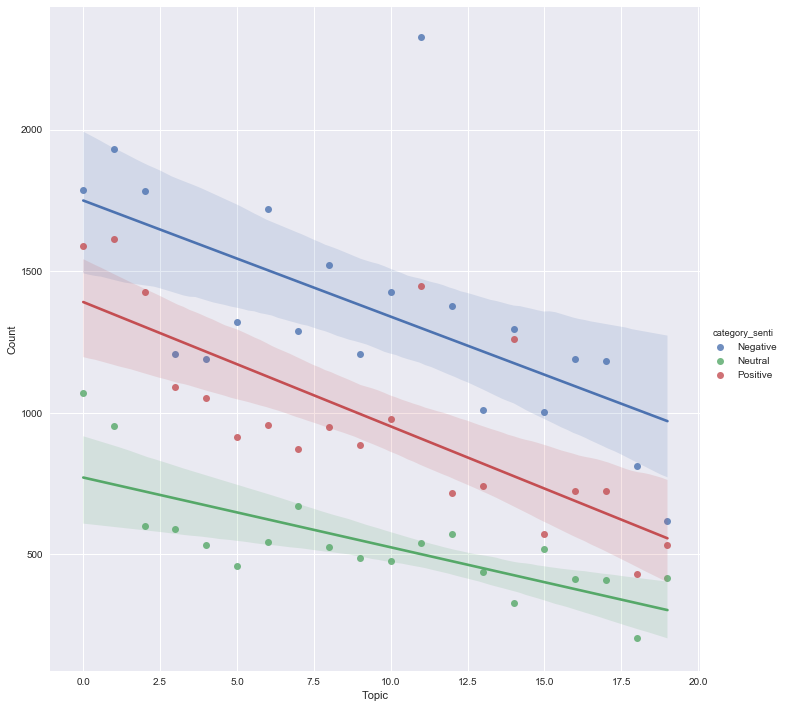

In [219]:
df1 = summary.groupby(['category_senti', 'topic']).count()
df1 = df1.reset_index()
import seaborn as sns
sns.set()

# Plot tip as a function of toal bill across days
g = sns.lmplot(x="topic", y="title", hue="category_senti",
               truncate=True, size=10, data=df1)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Topic", "Count")



#### Findings: 
* Topic 11: Has an outlier with negative sentiment. This topic was about Donald Trumps campaign. This has been a hot topic and the media likes to protray it it a very negative sense 
* Topic 2: This has the most positive sentiment. 

### Visualize Topic by news source (cnn and fox news)

In [205]:
df5 = summary[summary.source=="cnn"].copy()
df6 = summary[summary.source=="fox-news"].copy()
df7 = df5.append(df6)

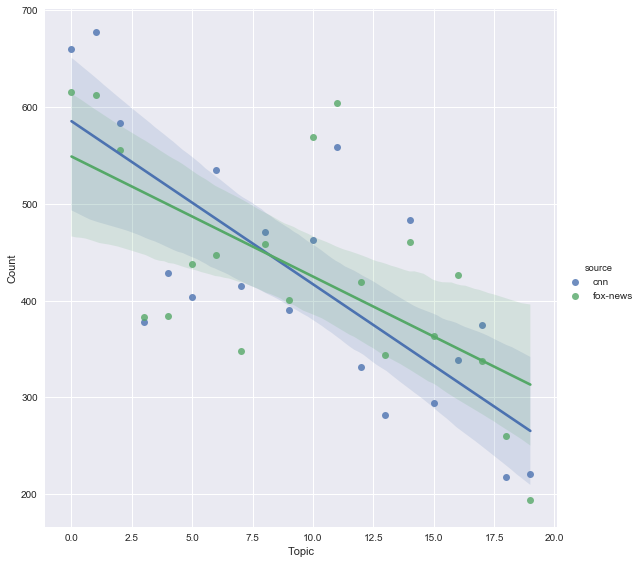

In [234]:
df1 = df7.groupby(['source', 'topic']).count()
df1 = df1.reset_index()
import seaborn as sns
sns.set()

# Plot tip as a function of toal bill across days
g = sns.lmplot(x="topic", y="title", hue="source",
               truncate=True, size=8, data=df1)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Topic", "Count")

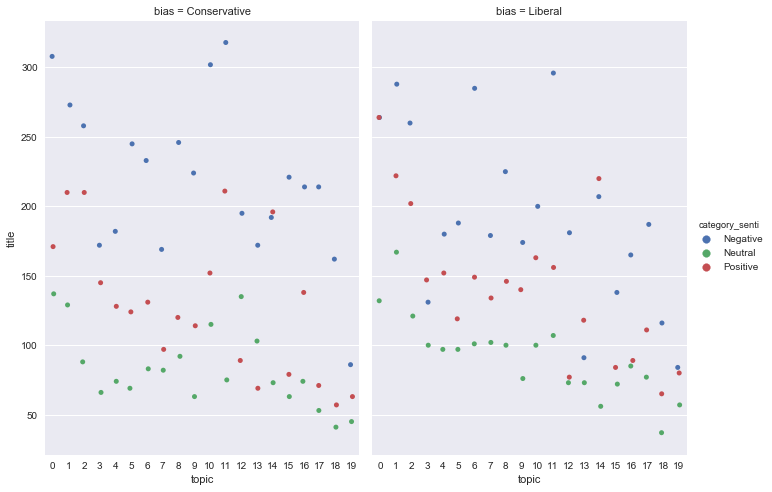

In [236]:
df1 = df7.groupby(['bias', 'topic', 'category_senti']).count()
df1 = df1.reset_index()



g = sns.factorplot(x="topic", y="title", hue="category_senti", col="bias", data=df1, kind="strip", jitter=True, size=7, aspect=.7);

### Findings:
* The conservative news sources tend to be more negative in general than liberal news sources
* The spread between positive and negative is much larger in conservative news. Does this indicate that the liber sources are more objective? 